In [1]:
import os

path = 'lastfm-dataset-1K'

if not os.path.exists(path):

  !wget http://mtg.upf.edu/static/datasets/last.fm/lastfm-dataset-1K.tar.gz
  !tar -xvzf lastfm-dataset-1K.tar.gz


--2021-05-30 08:14:51--  http://mtg.upf.edu/static/datasets/last.fm/lastfm-dataset-1K.tar.gz
Resolving mtg.upf.edu (mtg.upf.edu)... 84.89.139.55
Connecting to mtg.upf.edu (mtg.upf.edu)|84.89.139.55|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 672741554 (642M) [application/x-gzip]
Saving to: ‘lastfm-dataset-1K.tar.gz’

lastfm-dataset-1K.t 100%[===================>] 641.58M  1.29MB/s    in 9m 35s  

2021-05-30 08:24:26 (1.12 MB/s) - ‘lastfm-dataset-1K.tar.gz’ saved [672741554/672741554]

lastfm-dataset-1K/
lastfm-dataset-1K/userid-profile.tsv
lastfm-dataset-1K/README.txt
lastfm-dataset-1K/userid-timestamp-artid-artname-traid-traname.tsv


In [2]:
!ls

lastfm-dataset-1K  lastfm-dataset-1K.tar.gz  sample_data


In [3]:
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!ls drive/MyDrive/data

feature_df_with_emb.csv  spotify_features.csv


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import scipy.sparse as sp
import tensorflow as tf
from tqdm import tqdm
import pandas as pd
import numpy as np

from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

import datetime
import time 
import math
import os
%config Completer.use_jedi = False

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Config option `use_jedi` not recognized by `IPCompleter`.


In [6]:
path = "drive/MyDrive/data/feature_df_with_emb.csv"

feature_df_with_emb = pd.read_csv(path)

In [7]:
feature_df_with_emb.head()

,Unnamed: 0,artist,track,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,genres,popularity,genres_emb,emb_x,emb_y,emb_z
0,0,坂本龍一,Composition 0919 (Live_2009_4_15),0.806,0.413,5.0,-12.883,1.0,0.1560,0.987,0.794,0.1130,0.5290,105.089,330253.0,"['japanese soundtrack', 'japanese classical', ...",62,[7.3752766 4.8944925 0.94349271],7.375277,4.894493,0.943493
1,1,坂本龍一,Hibari (Live_2009_4_15),0.604,0.283,9.0,-19.811,0.0,0.0583,0.996,0.916,0.1140,0.2700,137.802,540133.0,"['japanese soundtrack', 'japanese classical', ...",62,[7.3752766 4.8944925 0.94349271],7.375277,4.894493,0.943493
2,2,坂本龍一,To Stanford (Live_2009_4_15),0.453,0.163,5.0,-20.922,1.0,0.0519,0.990,0.939,0.1010,0.0703,73.926,216853.0,"['japanese indie folk', 'japanese soundtrack',...",39,[7.3752766 4.8944925 0.94349271],7.375277,4.894493,0.943493
3,3,坂本龍一,Improvisation (Live_2009_4_15),0.217,0.012,5.0,-36.464,1.0,0.0376,0.991,0.859,0.0866,0.0376,80.714,384707.0,"['japanese soundtrack', 'japanese classical', ...",62,[7.3752766 4.8944925 0.94349271],7.375277,4.894493,0.943493
4,4,坂本龍一,Glacier (Live_2009_4_15),0.518,0.213,9.0,-28.790,0.0,0.2090,0.869,0.898,0.1030,0.0920,104.191,580707.0,"['japanese soundtrack', 'japanese classical', ...",62,[7.3752766 4.8944925 0.94349271],7.375277,4.894493,0.943493


In [8]:
# Load the dataset
df = pd.read_table('lastfm-dataset-1K/userid-timestamp-artid-artname-traid-traname.tsv', lineterminator='\n', warn_bad_lines=True, names=['user', 'timestamp', 'artist-id', 'artist', 'song-id', 'song'])
df_profile = pd.read_csv('lastfm-dataset-1K/userid-profile.tsv', sep='\t', error_bad_lines=False, warn_bad_lines=True, skiprows=1, names=['user', 'gender', 'age', 'country', 'signup'])

In [9]:
# Check if some songs share a common ID
grouped = df[['song-id', 'song']].groupby(['song-id']).nunique()

In [10]:
# Get rows with song names containing multiple rows
duplicated = df.loc[df['song-id'].isin(grouped[grouped['song'] > 1].index)]
duplicated = duplicated.drop(columns=['user', 'timestamp', 'artist', 'artist-id'])
containis_extra_rows = duplicated.apply(lambda x: pd.Series({'id': x[0], 'song': x[1], 'flag':'\n' in x[1]}), axis=1)
containis_extra_rows = containis_extra_rows.loc[containis_extra_rows['flag']]

In [11]:
# Iterate over those 5k rows to get the extra rows and correct the song name
for index, row in containis_extra_rows.iterrows():
    row_break = row['song'].split('\n', 1)
    song_name = row_break[0]
    df.loc[df['song-id'] == row['id'], 'song'] = song_name
    
    tsv = StringIO(row_break[1])
    df_extra = pd.read_csv(tsv, sep="\t", warn_bad_lines=True, names=['user', 'timestamp', 'artist-id', 'artist', 'song-id', 'song'])
    df = df.append(df_extra, ignore_index=True)

### Fix names

In [12]:
# Check if some songs share a common ID
grouped = df[['song-id', 'song']].groupby(['song-id']).nunique()

In [13]:
# Check how many ids has more than 1 song name
grouped[grouped['song'] > 1].shape[0]

200

In [14]:
ids_to_be_fixed = grouped[grouped['song'] > 1].index

In [15]:
df = df.set_index('song-id')

In [16]:
map_to_fix = df.groupby(df.index)['song'].head(1)

In [17]:
df.loc[ids_to_be_fixed, 'song'] = df.loc[ids_to_be_fixed].reset_index()['song-id'].map(lambda x: map_to_fix[x])
df = df.reset_index()

### Create matrix

In [95]:
matrix_init = df.groupby(['user', 'artist', 'song']).count()

In [96]:
matrix_init = matrix_init['timestamp']
matrix_init = matrix_init.map(lambda x: np.log(x))

In [97]:
matrix_init = matrix_init.reset_index()

In [98]:
def rating_scaler(row):
    row_array = np.array(row)
    a, new_range= 1, 4
    min_, max_ = row_array.min(), row_array.max()
    old_range = max_ - min_
    
    
    scaled_row = (new_range * (row_array - min_)) / (old_range + 1e-6)  + a
    return pd.Series(scaled_row)

In [99]:
matrix_init_scaled = matrix_init.groupby('user')['timestamp'].apply(rating_scaler)

In [100]:
matrix_init['timestamp'] = matrix_init_scaled.reset_index()['timestamp']

In [101]:
matrix_init['timestamp'].describe()

count    4.613822e+06
mean     1.713137e+00
std      8.444994e-01
min      1.000000e+00
25%      1.000000e+00
50%      1.535647e+00
75%      2.257866e+00
max      4.999999e+00
Name: timestamp, dtype: float64

In [24]:
feature_df_with_emb.head()
feature_df_with_emb['item'] = feature_df_with_emb.apply(lambda row: row[1]+'-'+row[2], axis=1)

### Merge data

In [25]:
matrix_init = matrix_init.rename({'timestamp':'rating', 'song':'track'}, axis=1)

In [26]:
matrix_extended = matrix_init.merge(feature_df_with_emb, on=['artist', 'track'])

In [27]:
matrix_extended.head()

,user,artist,track,rating,Unnamed: 0,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,genres,popularity,genres_emb,emb_x,emb_y,emb_z,item
0,user_000001,2562,Basin Dub,1.652605,1056,0.644,0.431,11.0,-7.676,1.0,0.206,0.0393,0.3,0.159,0.347,139.998,292769.0,"['classic dubstep', 'future garage', 'bass mus...",19,[5.3110935 6.1038699 3.31327275],5.311094,6.10387,3.313273,2562-Basin Dub
1,user_000451,2562,Basin Dub,1.617691,1056,0.644,0.431,11.0,-7.676,1.0,0.206,0.0393,0.3,0.159,0.347,139.998,292769.0,"['classic dubstep', 'future garage', 'bass mus...",19,[5.3110935 6.1038699 3.31327275],5.311094,6.10387,3.313273,2562-Basin Dub
2,user_000471,2562,Basin Dub,1.000000,1056,0.644,0.431,11.0,-7.676,1.0,0.206,0.0393,0.3,0.159,0.347,139.998,292769.0,"['classic dubstep', 'future garage', 'bass mus...",19,[5.3110935 6.1038699 3.31327275],5.311094,6.10387,3.313273,2562-Basin Dub
3,user_000508,2562,Basin Dub,2.129150,1056,0.644,0.431,11.0,-7.676,1.0,0.206,0.0393,0.3,0.159,0.347,139.998,292769.0,"['classic dubstep', 'future garage', 'bass mus...",19,[5.3110935 6.1038699 3.31327275],5.311094,6.10387,3.313273,2562-Basin Dub
4,user_000515,2562,Basin Dub,1.556342,1056,0.644,0.431,11.0,-7.676,1.0,0.206,0.0393,0.3,0.159,0.347,139.998,292769.0,"['classic dubstep', 'future garage', 'bass mus...",19,[5.3110935 6.1038699 3.31327275],5.311094,6.10387,3.313273,2562-Basin Dub


### Filter the dataset

In [28]:
matrix_extended.groupby('user').count()['rating'].describe()

count      992.000000
mean      4367.426411
std       5152.289753
min          1.000000
25%       1265.500000
50%       2945.000000
75%       5524.500000
max      65246.000000
Name: rating, dtype: float64

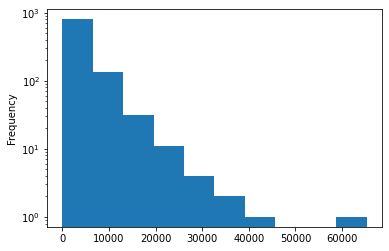

In [29]:
matrix_extended.groupby('user').count()['rating'].plot.hist()
plt.yscale('log')
plt.show()

In [30]:
matrix_extended.groupby('item').count()['rating'].describe()

count    929536.000000
mean          4.660914
std          10.819621
min           1.000000
25%           1.000000
50%           2.000000
75%           4.000000
max         346.000000
Name: rating, dtype: float64

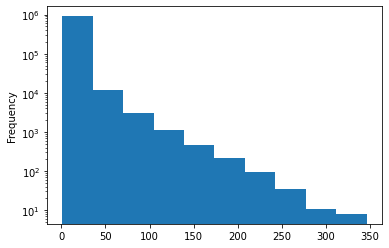

In [31]:
matrix_extended.groupby('item').count()['rating'].plot.hist()
plt.yscale('log')
plt.show()

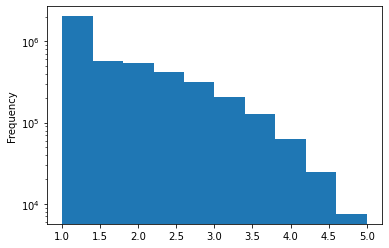

In [32]:
matrix_extended['rating'].plot.hist()
plt.yscale('log')
plt.show()

In [33]:
items_app = matrix_extended.groupby('item').count()['rating']
items_app = items_app.loc[items_app > 3.99].index
matrix_sampled = matrix_extended.copy()
matrix_sampled = matrix_sampled.set_index('item')
matrix_sampled = matrix_sampled.loc[items_app]
matrix_sampled = matrix_sampled.reset_index()
matrix_sampled = matrix_sampled.sample(frac=1)

In [34]:
matrix_sampled.groupby('user').count()['rating'].describe()

count      991.000000
mean      3399.972755
std       3809.005245
min          3.000000
25%       1064.500000
50%       2344.000000
75%       4265.000000
max      47788.000000
Name: rating, dtype: float64

### Sample Users

In [35]:
# no_users = 200
# users_list = matrix_extended.user.unique()
# users_sampled = np.random.choice(users_list, replace=False, size=no_users)
# matrix_sampled = matrix_extended.copy()
# matrix_sampled = matrix_sampled.set_index('user')
# matrix_sampled = matrix_sampled.loc[users_sampled]
# matrix_sampled = matrix_sampled.reset_index()
# matrix_sampled = matrix_sampled.sample(frac=1)
# matrix_sampled['item'] = matrix_sampled.apply(lambda row: row[1]+'-'+row[2], axis=1)

In [36]:
matrix_sampled.head()

,item,user,artist,track,rating,Unnamed: 0,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,genres,popularity,genres_emb,emb_x,emb_y,emb_z
1059749,Fugees-Recharge,user_000078,Fugees,Recharge,1.000000,185198,0.790,0.595,7.0,-12.699,1.0,0.2320,0.00696,0.0000,0.1430,0.466,100.947,310133.0,"['rap', 'new jersey rap', 'gangster rap', 'har...",71,[4.23720225 7.5225617 4.3797381 ],4.237202,7.522562,4.379738
3208166,Tv On The Radio-Shout Me Out,user_000310,Tv On The Radio,Shout Me Out,4.999998,107435,0.578,0.825,1.0,-6.054,1.0,0.0621,0.00201,0.2380,0.0998,0.503,150.059,255133.0,"['alternative dance', 'rock', 'brooklyn indie'...",62,[5.65567525 7.99145075 1.64971625],5.655675,7.991451,1.649716
2350438,Saint Etienne-On The Shore,user_000694,Saint Etienne,On The Shore,1.000000,102471,0.794,0.714,2.0,-9.939,1.0,0.1420,0.00389,0.8820,0.0785,0.912,120.008,246440.0,"['electronica', 'dream pop', 'electropop', 'br...",50,[6.08057615 7.8415661 1.81277595],6.080576,7.841566,1.812776
1563796,Les Négresses Vertes-Face À La Mer (Massive At...,user_000730,Les Négresses Vertes,Face À La Mer (Massive Attack Remix) (Full Ver...,1.000000,2306,0.744,0.604,10.0,-13.558,0.0,0.0884,0.03910,0.1890,0.1880,0.306,176.443,340400.0,"['nu jazz', 'trip hop', 'chanson', 'french roc...",45,[3.4129473 6.91451765 2.39292445],3.412947,6.914518,2.392924
225531,B.B. King-How Blue Can You Get?,user_000500,B.B. King,How Blue Can You Get?,1.000000,51272,0.498,0.484,7.0,-10.500,1.0,0.0922,0.32300,0.0108,0.7610,0.604,110.541,312027.0,"['traditional blues', 'classic rock', 'electri...",67,[4.25285965 7.37293385 0.13626011],4.252860,7.372934,0.136260


In [37]:
matrix_sampled['user_id'] = matrix_sampled['user'].astype('category').cat.codes
matrix_sampled['item_id'] = matrix_sampled['item'].astype('category').cat.codes

In [38]:
X = matrix_sampled[['user_id', 
              'item_id',
              'danceability',
              'energy',
              'speechiness', 
              'acousticness', 
              'instrumentalness', 
              'liveness',
              'valence', 
              'tempo', 
              'popularity', 
              'emb_x', 
              'emb_y',
              'emb_z']]
y = matrix_sampled['rating']
groups = matrix_sampled['user_id']

In [39]:
# Change splitting to be by index using https://stackoverflow.com/questions/53490497/getting-validation-set-from-train-set-by-using-percentage-from-groupby-in-pand
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=groups)

In [40]:
no_users, no_items, no_factors = matrix_sampled['user_id'].nunique(), matrix_sampled['item_id'].nunique(), 100

In [41]:
no_users

991

In [42]:
no_items

246166

### Models

In [43]:
def create_shallow_model(no_factors, no_users, no_items):
    # User branch
    user_id = tf.keras.layers.Input(shape=[1], name='user_id')
    user_matrix = tf.keras.layers.Embedding(no_users+1, no_factors, name='user_matrix')(user_id)
    user_vector = tf.keras.layers.Flatten(name='user_vector')(user_matrix)
    # Item branch
    item_id = tf.keras.layers.Input(shape=[1], name='item_id')
    item_matrix = tf.keras.layers.Embedding(no_items+1, no_factors, name='item_matrix')(item_id)
    item_vector = tf.keras.layers.Flatten(name='item_vector')(item_matrix)
    # Dot product 
    vectors_product = tf.keras.layers.dot([user_vector, item_vector], axes=1, normalize=False)
    # Model definition
    model = tf.keras.models.Model(inputs=[user_id, item_id], outputs=[vectors_product], name='shallow_model')
    return model

In [44]:
model = create_shallow_model(no_factors, no_users, no_items)

In [45]:
model.summary()

Model: "shallow_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_id (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_id (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_matrix (Embedding)         (None, 1, 100)       99200       user_id[0][0]                    
__________________________________________________________________________________________________
item_matrix (Embedding)         (None, 1, 100)       24616700    item_id[0][0]                    
______________________________________________________________________________________

In [46]:
def create_deep_model(no_factors, no_users, no_items):
    # User branch
    user_id = tf.keras.layers.Input(shape=[1], name='user_id')
    user_matrix = tf.keras.layers.Embedding(no_users+1, no_factors, name='user_matrix')(user_id)
    user_vector = tf.keras.layers.Flatten(name='user_vector')(user_matrix)
    # Item branch
    item_id = tf.keras.layers.Input(shape=[1], name='item_id')
    item_matrix = tf.keras.layers.Embedding(no_items+1, no_factors, name='item_matrix')(item_id)
    item_vector = tf.keras.layers.Flatten(name='item_vector')(item_matrix)
    # Concantenation
    vectors_concat = tf.keras.layers.Concatenate()([user_vector, item_vector])
    vectors_concat_dropout = tf.keras.layers.Dropout(0.2)(vectors_concat)
    # Backbone 
    dense_1 = tf.keras.layers.Dense(64,name='fc3')(vectors_concat_dropout)
    dropout_1 = tf.keras.layers.Dropout(0.2,name='d3')(dense_1)
    dense_2 = tf.keras.layers.Dense(32,name='fc4', activation='relu')(dropout_1)
    dropout_2 = tf.keras.layers.Dropout(0.2,name='d4')(dense_2)
    dense_3 = tf.keras.layers.Dense(16,name='fc5', activation='relu')(dropout_2)
    dropout_3 = tf.keras.layers.Dropout(0.2,name='d5')(dense_3)
    dense_4 = tf.keras.layers.Dense(8,name='fc6', activation='relu')(dropout_3)
    dense_4_output = tf.keras.layers.Dense(1, activation='relu', name='activation')(dense_4)
    # Model definition
    model = tf.keras.models.Model(inputs=[user_id, item_id], outputs=[dense_4_output], name='deep_model')
    return model

In [47]:
model = create_deep_model(no_factors, no_users, no_items)

### Model training

In [48]:
# Input-output data definition
X_train_arr = [X_train.user_id, X_train.item_id]

# Model creation
model = create_deep_model(no_factors, no_users, no_items)

# Model compiling 
model.compile(loss=tf.keras.losses.MeanSquaredError())

# Model training
model.fit(X_train_arr, y_train, epochs=10, batch_size=2048, shuffle=True)

Epoch 1/10
1317/1317 [==============================] - 138s 104ms/step - loss: 0.7132
Epoch 2/10
1317/1317 [==============================] - 136s 104ms/step - loss: 0.6305
Epoch 3/10
1317/1317 [==============================] - 137s 104ms/step - loss: 0.6120
Epoch 4/10
1317/1317 [==============================] - 137s 104ms/step - loss: 0.5963
Epoch 5/10
1317/1317 [==============================] - 137s 104ms/step - loss: 0.5835
Epoch 6/10
1317/1317 [==============================] - 137s 104ms/step - loss: 0.5718
Epoch 7/10
1317/1317 [==============================] - 137s 104ms/step - loss: 0.5612
Epoch 8/10
1317/1317 [==============================] - 137s 104ms/step - loss: 0.5521
Epoch 9/10
1317/1317 [==============================] - 137s 104ms/step - loss: 0.5438
Epoch 10/10
1317/1317 [==============================] - 137s 104ms/step - loss: 0.5364


### Prediction

In [49]:
# Predictions in the training set
# X_train = [X_train.user_id, X_train.item_id]
y_train_pred = model.predict(X_train_arr, batch_size=2048)

In [50]:
X_test.head()

,user_id,item_id,danceability,energy,speechiness,acousticness,instrumentalness,liveness,valence,tempo,popularity,emb_x,emb_y,emb_z
528544,564,38472,0.484,0.0577,0.0344,0.964000,0.000001,0.1540,0.4590,103.293,63,5.873042,8.081335,1.531157
2144341,389,160432,0.462,0.9100,0.0359,0.000086,0.046900,0.0863,0.6160,155.690,70,5.503772,7.826161,1.485511
2652579,189,197518,0.301,0.9980,0.1270,0.000075,0.000020,0.3570,0.0499,113.314,7,7.952354,9.167381,-0.507604
491185,861,35379,0.353,0.8830,0.1500,0.000782,0.000000,0.2480,0.6500,92.634,57,5.683891,7.662214,1.330023
37148,275,3074,0.734,0.6430,0.0310,0.119000,0.077400,0.1560,0.9190,126.421,56,5.508577,7.457070,1.304209


In [51]:
# Predictions in the test set
X_test_arr = [X_test.user_id, X_test.item_id]
y_test_pred = model.predict(X_test_arr, batch_size=2048)

### Evaluation

In [52]:
from sklearn.metrics import mean_squared_error
print('Train RMSE:', mean_squared_error(y_train.values, y_train_pred, squared=False))
print('Test RMSE:', mean_squared_error(y_test.values, y_test_pred, squared=False))

Train RMSE: 0.7228441999960579
Test RMSE: 0.8075250329882625


In [144]:
def get_test_predictions(model, test_ratings):
  predictions_li = []
  for user_id, user_test_rating in tqdm(test_ratings.groupby('user_id'), position=0, leave=True):
        # Retrieve the unseen items
        user_df = test_ratings[(test_ratings['user_id'] == user_id)]
        test_pids = user_df['item_id'].values
        relevant_pids = set(user_df.loc[user_df['rating'] > 1, 'item_id'].values)
        if len(relevant_pids) == 0:
          continue
        # Create testing dataframe
        test_df = pd.DataFrame({'user_id': user_id, 'item_id': test_pids})
        test_set = [test_df.user_id, test_df.item_id]
        # Make rating predictions for all items for that user
        predictions = model.predict(test_set, batch_size=2048)
        # predictions = pred_func(model, user_id, pid_array, train_ratings)
        predictions = predictions.reshape(-1)
        irrelevant_pids = set(test_pids).difference(relevant_pids)
        predictions_relevant = predictions[user_df['rating'] > 1]
        predictions_irrelevant = predictions[user_df['rating'] == 1]
        predictions_dict = {'user_id': user_id,
                            'predictions': predictions,
                            'test_pids': test_pids,
                            'relevant_pids': relevant_pids,
                            'irrelevant_pids': irrelevant_pids,
                            'predictions_relevant': predictions_relevant,
                            'predictions_irrelevant': predictions_irrelevant}
        predictions_li.append(predictions_dict)

  return pd.DataFrame(predictions_li)


In [145]:
X_test_arr = np.array(X_test_arr)
test_ratings = pd.DataFrame({'user_id': X_test_arr[0, :], 'item_id':X_test_arr[1, :], 'rating': y_test})
predictions_df = get_test_predictions(model, test_ratings)

100%|██████████| 991/991 [01:01<00:00, 16.03it/s]


In [133]:
predictions_df.loc[0, 'predictions']

array([1.7855494, 1.8012253, 1.9349527, 2.107413 , 2.0764825, 2.0859077,
       1.8187356, 2.0910914, 1.8108256, 2.0648923, 1.7424434, 1.7963662,
       1.6870184, 1.7402844, 1.7401642, 2.4860175, 2.1383638, 1.8016951,
       2.5408595, 2.13191  , 1.9946091, 2.5114336, 2.339808 , 1.7864423,
       2.0424352, 1.8036003, 1.8008064, 2.3525774, 2.746745 , 2.0930688,
       2.208622 , 2.46319  , 1.3170494, 1.644284 , 2.361813 , 1.7221575,
       1.9082398, 1.9296167, 2.4785051, 2.0071716, 1.8343598, 1.735512 ,
       2.1122608, 2.2410102, 1.98894  , 2.404959 , 1.998322 , 2.087327 ,
       1.946955 , 2.0472658, 1.9835501, 1.7561387, 2.1748564, 1.4185603,
       1.7323217, 2.0032191, 2.38165  , 2.3526568, 2.201194 , 2.3699372,
       2.0722616, 1.5424293, 2.1098046, 1.4127584, 1.5687667, 1.6875765,
       2.0537727, 1.7872354, 1.8099759, 1.9750255, 2.0772395, 1.9269843,
       2.0335484, 1.4987793, 1.881941 , 2.0275495, 1.6024481, 1.7391253,
       1.7339112, 2.2587628, 2.131493 , 1.7744585, 

In [147]:
# Predictions analysis (Used to debug the recommender system prediction range)
predictions_df['mean'] = predictions_df['predictions'].map(lambda a: a.mean())
predictions_df['median'] = predictions_df['predictions'].map(lambda a:np.median(a))
predictions_df['min'] = predictions_df['predictions'].map(lambda a: a.min())
predictions_df['max'] = predictions_df['predictions'].map(lambda a: a.max())
predictions_df['25th'] = predictions_df['predictions'].map(lambda a: np.percentile(a, q=25))
predictions_df['75th'] = predictions_df['predictions'].map(lambda a: np.percentile(a, q=75))
# Predictions relevant analysis (Used to debug the recommender system prediction range)
predictions_df['mean_relevant'] = predictions_df['predictions_relevant'].map(lambda a: a.mean())
predictions_df['median_relevant'] = predictions_df['predictions_relevant'].map(lambda a:np.median(a))
predictions_df['min_relevant'] = predictions_df['predictions_relevant'].map(lambda a: a.min())
predictions_df['max_relevant'] = predictions_df['predictions_relevant'].map(lambda a: a.max())
predictions_df['25th_relevant'] = predictions_df['predictions_relevant'].map(lambda a: np.percentile(a, q=25))
predictions_df['75th_relevant'] = predictions_df['predictions_relevant'].map(lambda a: np.percentile(a, q=75))
# Predictions irrelevant analysis (Used to debug the recommender system prediction range)
predictions_df['mean_irrelevant'] = predictions_df['predictions_irrelevant'].map(lambda a: a.mean())
predictions_df['median_irrelevant'] = predictions_df['predictions_irrelevant'].map(lambda a:np.median(a))
predictions_df['min_irrelevant'] = predictions_df['predictions_irrelevant'].map(lambda a: a.min())
predictions_df['max_irrelevant'] = predictions_df['predictions_irrelevant'].map(lambda a: a.max())
predictions_df['25th_irrelevant'] = predictions_df['predictions_irrelevant'].map(lambda a: np.percentile(a, q=25))
predictions_df['75th_irrelevant'] = predictions_df['predictions_irrelevant'].map(lambda a: np.percentile(a, q=75))

In [151]:
predictions_df['median_relevant'].median()

1.7722660303115845

In [63]:
def precision_at_k(user_test):
    precisions = []
    # For each user
    for user_id, predictions in tqdm(predictions_df):
        # Sort the items and het the top k
        top_k = predictions > 1.1
        top_k_items = set(np.array(test_pids)[top_k])
        # Compute precision as per definition
        precisions.append(len(top_k_items & relevant_pids) / top_k.sum())
    return precisions

In [66]:
precisions = precision_at_k(model, test_ratings)

100%|██████████| 991/991 [00:59<00:00, 16.72it/s]


In [67]:
print(test_ratings['rating'].min(), test_ratings['rating'].max(), test_ratings['rating'].mean(), test_ratings['rating'].median())

1.0 4.999999410220268 1.763283649950951 1.585403708701425


In [68]:
np.mean(precisions), np.std(precisions)

(0.5085410770777479, 0.20379579805392506)

In [69]:
### EXERCISE CELL ###
def recall_at_k(model, test_ratings):
    recalls = []
    for user_id, user_test_rating in tqdm(test_ratings.groupby('user_id')):
        # Retrieve the unseen items
        user_df = test_ratings[(test_ratings['user_id'] == user_id)]
        test_pids = user_df['item_id'].values
        relevant_pids = set(user_df.loc[user_df['rating'] > 1, 'item_id'].values)
        if len(relevant_pids) == 0:
          continue
        # Create testing dataframe
        test_df = pd.DataFrame({'user_id': user_id, 'item_id': test_pids})
        test_set = [test_df.user_id, test_df.item_id]
        # Make rating predictions for all items for that user
        predictions = model.predict(test_set, batch_size=2048)
        # predictions = pred_func(model, user_id, pid_array, train_ratings)
        predictions = predictions.reshape(-1)
        # Sort the items and het the top k
        top_k = predictions > 1.1
        top_k_items = set(np.array(test_pids)[top_k])
        recalls.append(len(top_k_items & relevant_pids) / len(relevant_pids))
    return recalls

In [70]:
recalls = recall_at_k(model, test_ratings)

100%|██████████| 991/991 [00:58<00:00, 16.84it/s]


In [71]:
np.mean(recalls), np.std(recalls)

(1.0, 0.0)

In [72]:
### EXERCISE CELL ###
def map_at_k(model, test_ratings, k=100):
    maps = []
    for user_id, user_test_rating in tqdm(test_ratings.groupby('user_id')):
        # Retrieve the unseen items
        user_df = test_ratings[(test_ratings['user_id'] == user_id)]
        test_pids = user_df['item_id'].values
        relevant_pids = set(user_df.loc[user_df['rating'] > 1, 'item_id'].values)
        if len(relevant_pids) == 0:
          continue
        # Create testing dataframe
        test_df = pd.DataFrame({'user_id': user_id, 'item_id': test_pids})
        test_set = [test_df.user_id, test_df.item_id]
        # Make rating predictions for all items for that user
        predictions = model.predict(test_set, batch_size=2048)
        # predictions = pred_func(model, user_id, pid_array, train_ratings)
        predictions = predictions.reshape(-1)
        partial_maps = []
        top_k = list(np.argsort(predictions)[:k])
        top_k_items = test_df.iloc[top_k]['item_id'].values
        for rank, item_id in enumerate(top_k_items):
            if item_id in relevant_pids:
                partial_maps.append(len(set(top_k_items[:rank+1]) & relevant_pids) / float(rank+1))
        maps.append(.0 if len(partial_maps) == 0 else np.sum(partial_maps) / float(k))
    return maps

In [73]:
maps = map_at_k(model, test_ratings, k=100)

100%|██████████| 991/991 [00:59<00:00, 16.64it/s]


In [74]:
np.mean(maps), np.std(maps)

(0.2050060413414224, 0.17361770247594785)